# STEP 1 : 시계열 데이터 준비
## 삼성 5년치
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)
- **날짜를 5년으로 늘려서 준비!**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6로 지정해 줍니다.

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2016-08-31    32400.0
2016-09-01    31740.0
2016-09-02    31940.0
2016-09-05    32120.0
2016-09-06    32860.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

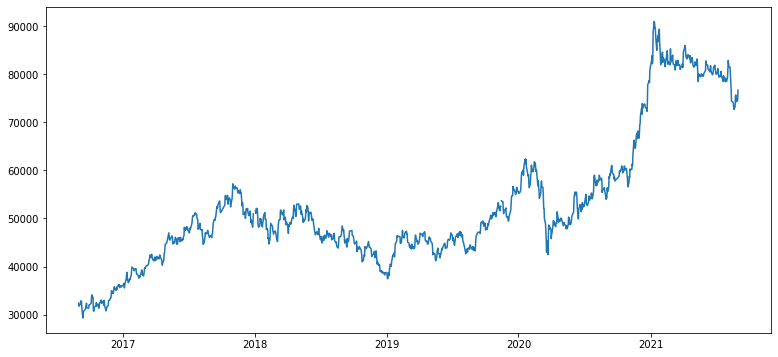

In [2]:
# 그래프 확인

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [3]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

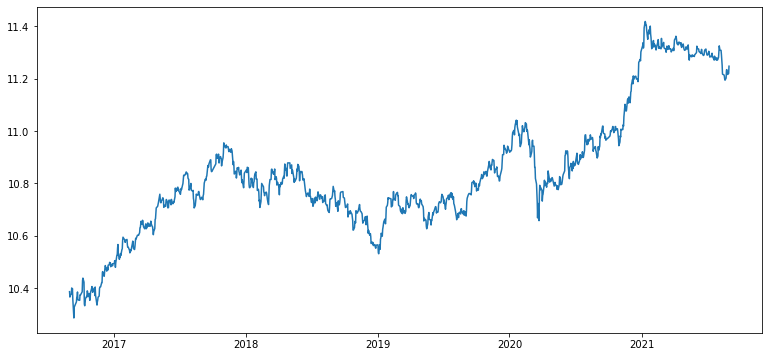

In [4]:
# 로그 변환 시도 후 다시 그래프 확인
ts_log = np.log(ts)
plt.plot(ts_log)

- 그래프 상으로는 큰 변화가 안 느껴져서 수치로 비교를 해봐야 할 것 같다.

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인


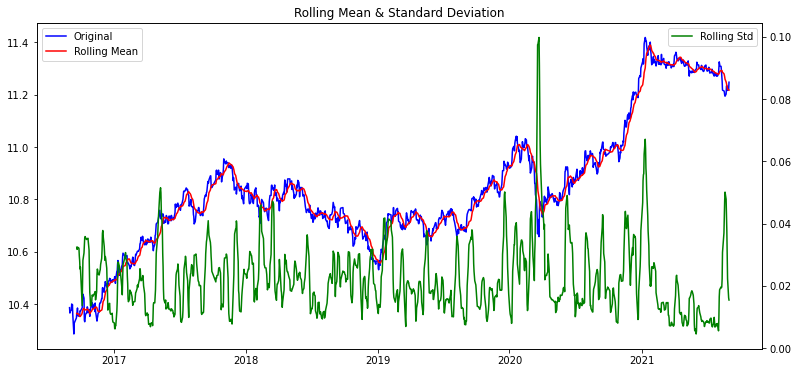

In [5]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
     # 축을 2개를 사용해서 눈에 잘 보이게 해줌
    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()
    orig, = ax1.plot(timeseries, color='blue',label='Original')    
    mean, = ax1.plot(rolmean, color='red', label='Rolling Mean')
    std, = ax2.plot(rolstd, color='green', label='Rolling Std')
    label = [orig, mean]
    ax1.legend(label, [i.get_label() for i in label], loc=2)
    ax2.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12) # timestep은 1년으로

In [6]:
#정량적 Augmented Dicky-Fuller Test

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts) # 로그 변환 전

Results of Dickey-Fuller Test:
Test Statistic                   -1.057416
p-value                           0.731752
#Lags Used                       18.000000
Number of Observations Used    1209.000000
Critical Value (1%)              -3.435770
Critical Value (5%)              -2.863934
Critical Value (10%)             -2.568044
dtype: float64


In [7]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.352166
p-value                           0.604982
#Lags Used                        0.000000
Number of Observations Used    1227.000000
Critical Value (1%)              -3.435691
Critical Value (5%)              -2.863898
Critical Value (10%)             -2.568026
dtype: float64


- p값이 좀 줄어들기는 했지만 여전히 귀무가설을 기각 할 수 있는 수준은 아니다.

- 이걸로 시계열이 안정적이라고 주장하면 이상한 사람 취급을 받을 듯

- 차분이 필요하므로 `d`는 1 이상의 값이 나올것이다.

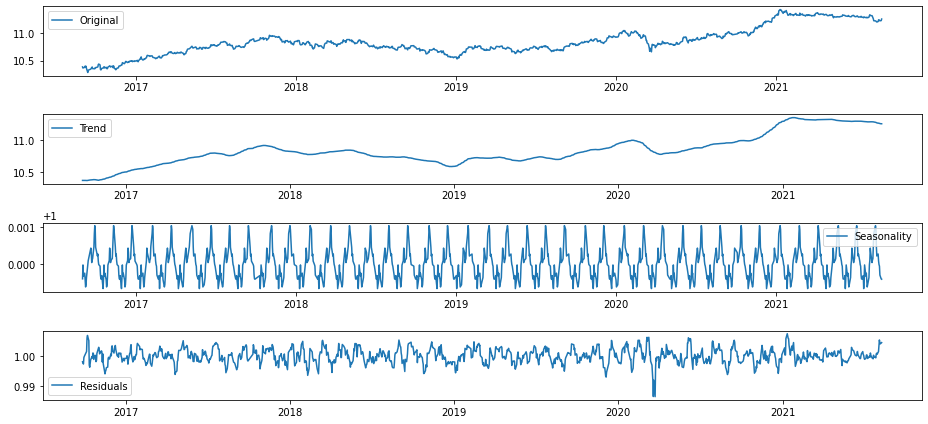

In [8]:
#시계열 분해 (Time Series Decomposition)
# model: 주기적 변화의 크기나 전체적인 level의 variation이 일정할 때에는 additive
# model: 시간의 흐름에 비례하게 변화한다면 multiplicative
# 경제 지표 관련 타임시리즈는 multiplicative model을 따르는 경우가 많다
# https://yoongaemii.github.io/seasonal_decomposition

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.027767e+01
p-value                        3.852391e-18
#Lags Used                     1.700000e+01
Number of Observations Used    1.180000e+03
Critical Value (1%)           -3.435904e+00
Critical Value (5%)           -2.863992e+00
Critical Value (10%)          -2.568076e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

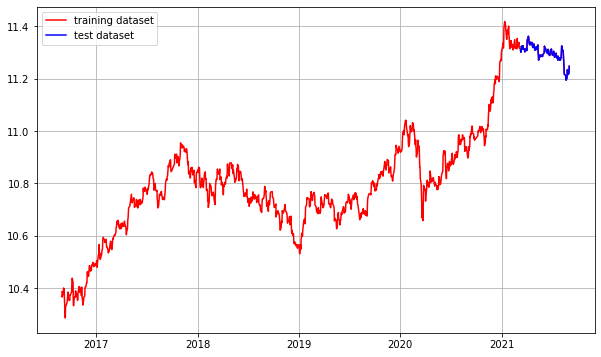

In [10]:
# 최근날짜 기준으로 10%를 테스트 셋으로

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

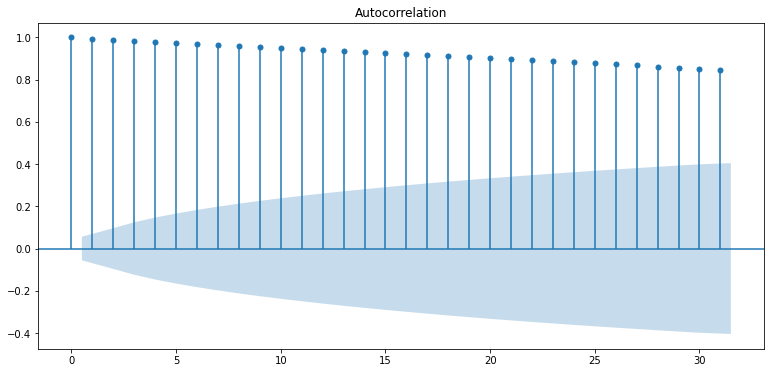

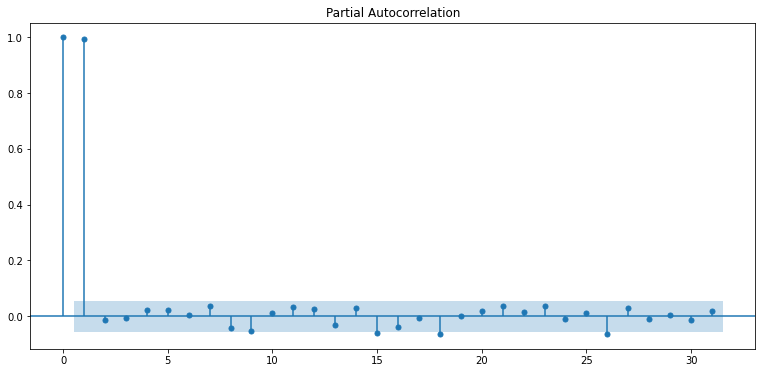

In [11]:
# ACF, PACF 그려보기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- `PACF` 1의 Time lag에서 1에 가까운 값이 나오고 이후에 급격히 감소
- 다른 시차와 관련성이 없으므로 AR 모델의 시차는 `p=1`로 설정하면 될 것 같다
- `ACF` 그래프는 아주 서서히 감소하고 있어서 `q` 값을 정할 수는 없다.
- (1,0,0) 일단 시도!

Results of Dickey-Fuller Test:
Test Statistic                  -34.167317
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1226.000000
Critical Value (1%)              -3.435695
Critical Value (5%)              -2.863900
Critical Value (10%)             -2.568027
dtype: float64


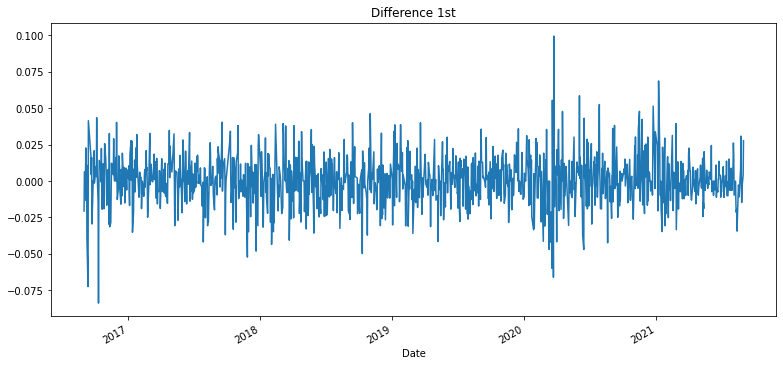

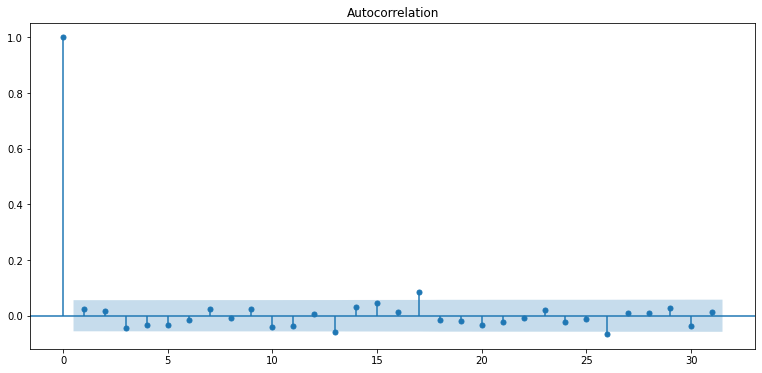

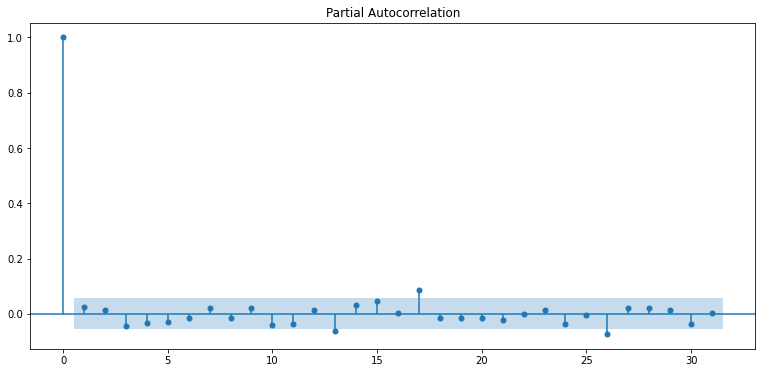

In [12]:
# 차분 안정성 확인

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# ACF, PACF 다시 확인
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

- 1차 차분만에 이정도 안정성이면 2차 차분까지는 필요 없을 것 같다.
- `d=1`도 넘치는 감이 있다. `p`랑 `q`가 모두 0이 되는데...
- (0,1,0)가 의미 있는 값인가..??
- AR 모델이라고 생각하고 (1,1,0)도 시도!

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [13]:
# ARIMA 모델 빌드와 훈련
# trend: 상수를 포함할지 여부
# disp: 수렴정보 출력 여부

# Build Model
model_100 = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model_100.fit(trend='nc', disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1105
Model:                     ARMA(1, 0)   Log Likelihood                2895.757
Method:                       css-mle   S.D. of innovations              0.018
Date:                Wed, 01 Sep 2021   AIC                          -5787.515
Time:                        17:31:50   BIC                          -5777.499
Sample:                             0   HQIC                         -5783.727
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.Close     1.0000   9.67e-06   1.03e+05      0.000       1.000       1.000
                                    Roots                                    
                  Real          Imaginary         

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

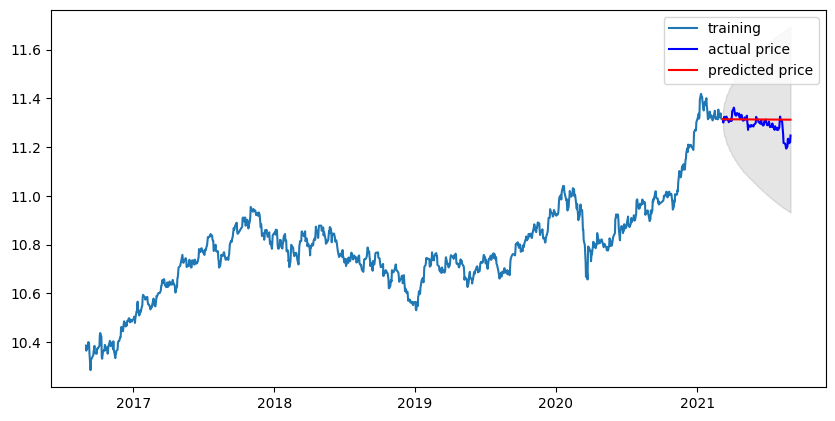

In [14]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [15]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8459927.787038881
MAE:  2050.2830730858213
RMSE:  2908.5955007595817
MAPE: 2.62%


In [16]:
# ARIMA 모델 빌드와 훈련

# Build Model
model_110 = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model_110.fit(trend='nc', disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1104
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2899.763
Method:                       css-mle   S.D. of innovations              0.018
Date:                Wed, 01 Sep 2021   AIC                          -5795.527
Time:                        17:31:50   BIC                          -5785.513
Sample:                             1   HQIC                         -5791.739
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.D.Close     0.0191      0.030      0.636      0.525      -0.040       0.078
                                    Roots                                    
                  Real          Imaginary   

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

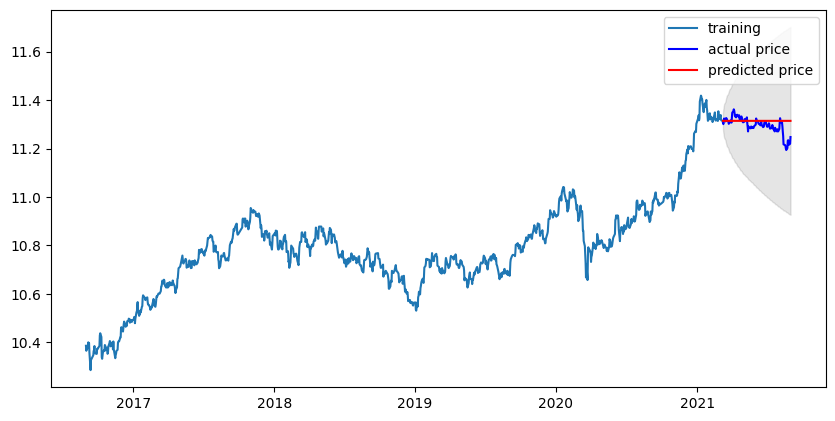

In [17]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [18]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8821176.26921799
MAE:  2103.192942749818
RMSE:  2970.046509605193
MAPE: 2.68%


- 모수를 조절해봤으나 둘 다 3% 수준에 머물렀다.

- t- test 값을 줄이려고 상수를 제거해봤는데 썩 마음에는 안 든다. 더 줄어야 할 것 같은데 ㅠㅠ

- 차분이 0일때 결과가 더 좋다니 .. 왜때문에..? ;ㅂ;

## 최종결과 (1, 0, 0) 일 때 2.62%

---
---
---

# STEP 1 : 시계열 데이터 준비
## 빙그레 5년치
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


In [19]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/005180.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2016-08-31    55200.0
2016-09-01    54900.0
2016-09-02    56000.0
2016-09-05    55600.0
2016-09-06    55900.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

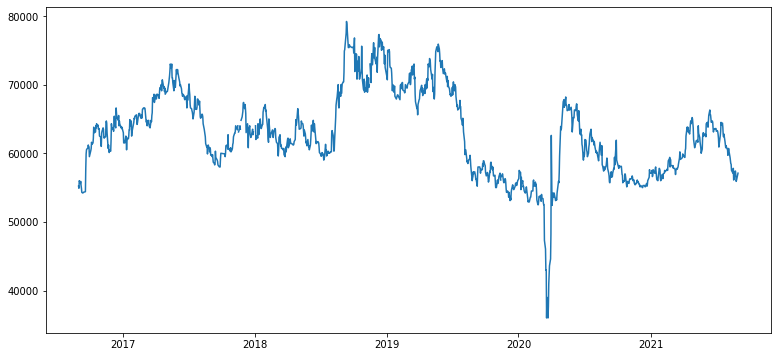

In [20]:
# 그래프 확인
# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [21]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

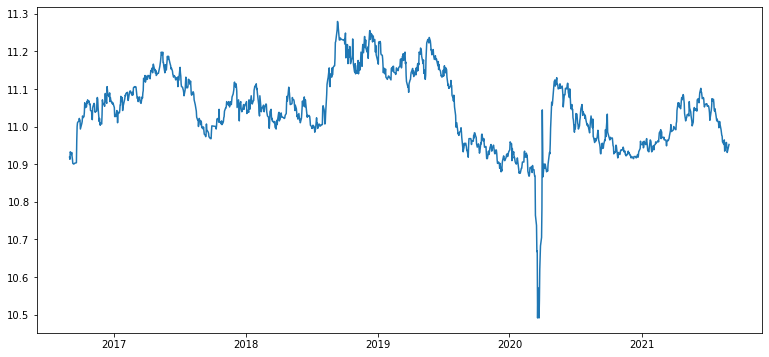

In [22]:
# 로그 변환 시도 후 다시 그래프 확인
ts_log = np.log(ts)
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인


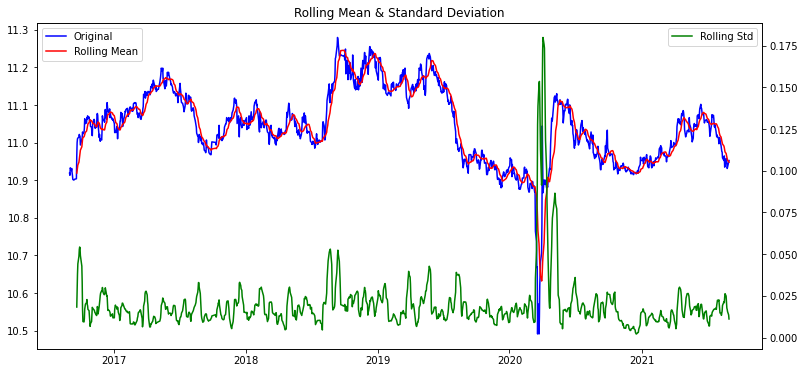

In [23]:
# 정성적 그래프 분석
    
plot_rolling_statistics(ts_log, window=12)

In [24]:
#정량적 Augmented Dicky-Fuller Test
    
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -2.781545
p-value                           0.060959
#Lags Used                       17.000000
Number of Observations Used    1210.000000
Critical Value (1%)              -3.435766
Critical Value (5%)              -2.863932
Critical Value (10%)             -2.568043
dtype: float64


In [25]:
#정량적 Augmented Dicky-Fuller Test
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -2.881075
p-value                           0.047593
#Lags Used                       17.000000
Number of Observations Used    1210.000000
Critical Value (1%)              -3.435766
Critical Value (5%)              -2.863932
Critical Value (10%)             -2.568043
dtype: float64


- 로그 변환 후 p value 값이 0.05 이하로 내려갔으므로 이 상태로도 안정적인 것 같다

- `d=0`을 시도해볼 수 있겠다.

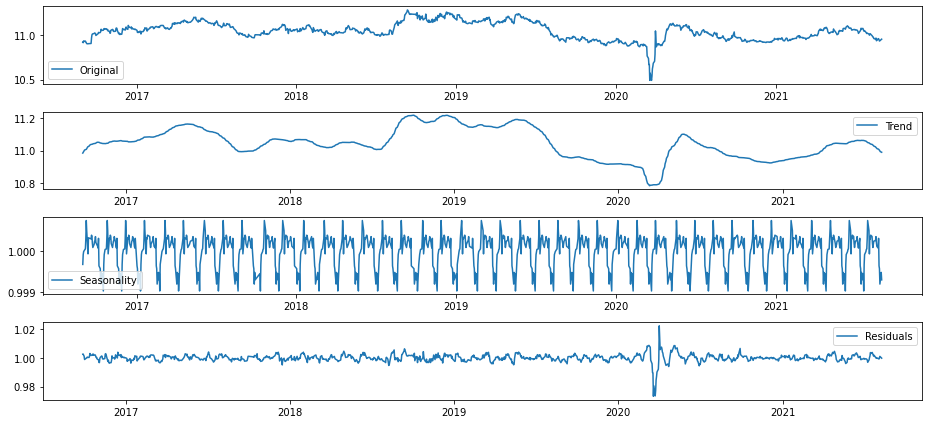

In [26]:
#시계열 분해 (Time Series Decomposition)
# model: 주기적 변화의 크기나 전체적인 level의 variation이 일정할 때에는 additive
# model: 시간의 흐름에 비례하게 변화한다면 multiplicative
# 경제 지표 관련 타임시리즈는 multiplicative model을 따르는 경우가 많다
# https://yoongaemii.github.io/seasonal_decomposition

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [27]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.524133e+00
p-value                        3.009465e-16
#Lags Used                     2.000000e+01
Number of Observations Used    1.177000e+03
Critical Value (1%)           -3.435918e+00
Critical Value (5%)           -2.863999e+00
Critical Value (10%)          -2.568079e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

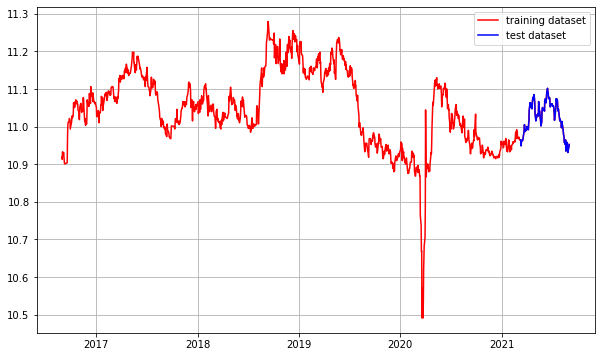

In [28]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

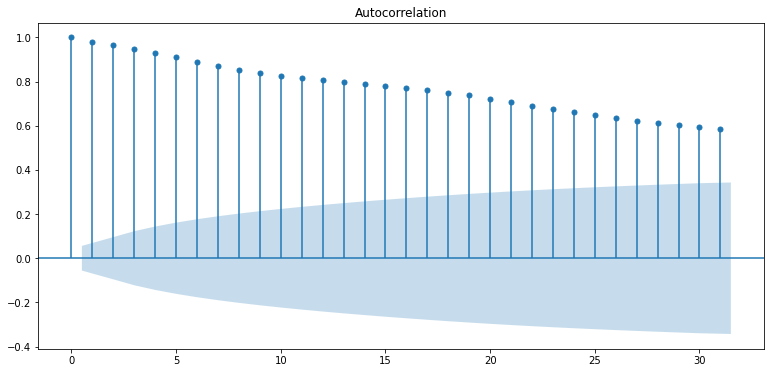

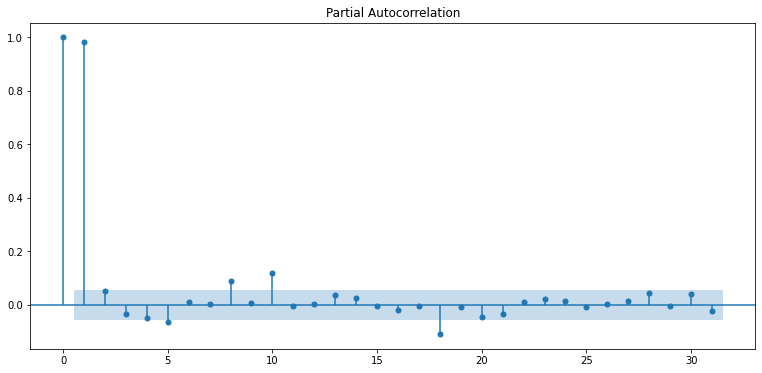

In [29]:
# ACF, PACF 그려보기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- `PACF` 그래프를 볼 때 `p=1`이 매우 적합
- `ACF`는 점차적으로 감소하고 있어서 `MA`를 고려할 필요가 없다면 `q=0`으로 둘 수 있을 것 같다.
- (1,0,0) 시도!

Results of Dickey-Fuller Test:
Test Statistic                -1.415078e+01
p-value                        2.163782e-26
#Lags Used                     8.000000e+00
Number of Observations Used    1.218000e+03
Critical Value (1%)           -3.435730e+00
Critical Value (5%)           -2.863916e+00
Critical Value (10%)          -2.568035e+00
dtype: float64


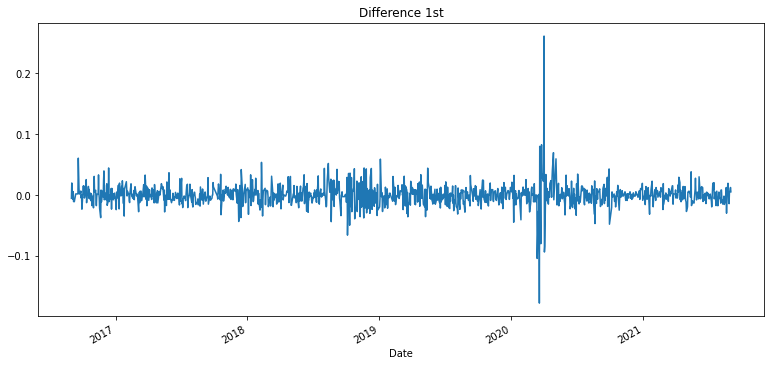

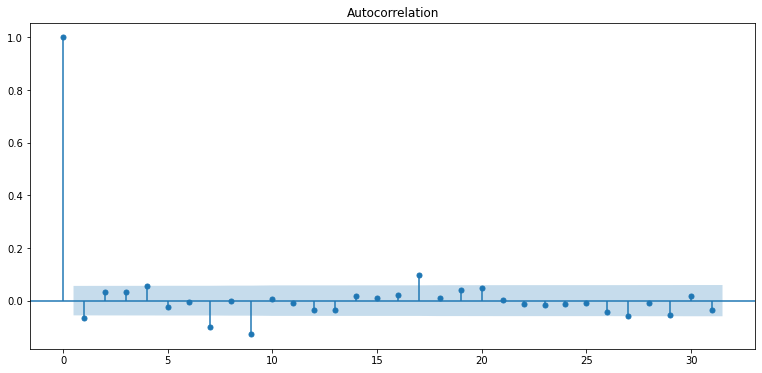

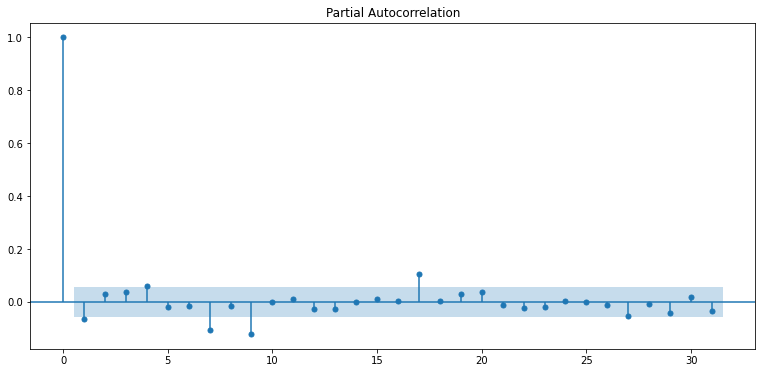

In [30]:
# 차분 안정성 확인

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# ACF, PACF 다시 확인
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

- 삼성과 비슷한 형태가 나오는 걸 보면 `d=1`에서의 결과가 더 안좋을 가능성이 있다.
- 일단 (1,1,0)도 시도 해보자!

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [31]:
# ARIMA 모델 빌드와 훈련

# Build Model
model_100 = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model_100.fit(trend='c', disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1105
Model:                     ARMA(1, 0)   Log Likelihood                2809.979
Method:                       css-mle   S.D. of innovations              0.019
Date:                Wed, 01 Sep 2021   AIC                          -5613.958
Time:                        17:31:53   BIC                          -5598.935
Sample:                             0   HQIC                         -5608.276
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.0356      0.032    345.436      0.000      10.973      11.098
ar.L1.Close     0.9829      0.005    181.746      0.000       0.972       0.994
                                    Roots       

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

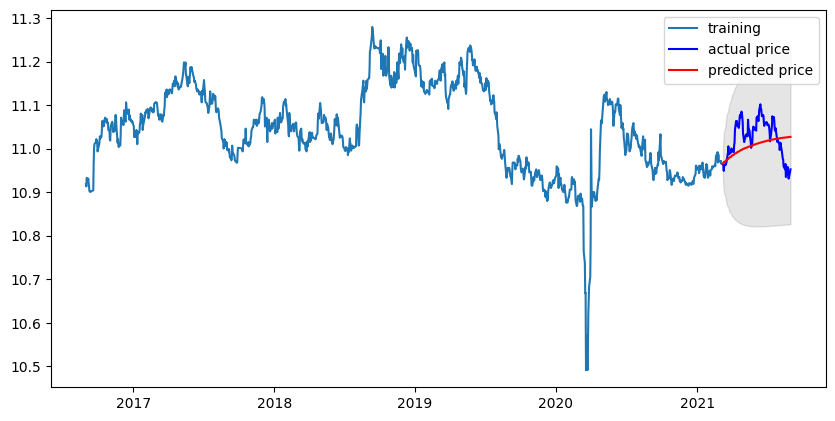

In [32]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [33]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8366514.231655035
MAE:  2409.14129021989
RMSE:  2892.4927366641796
MAPE: 3.90%


In [34]:
# ARIMA 모델 빌드와 훈련

# Build Model
model_110 = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model_110.fit(trend='c', disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1104
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2807.395
Method:                       css-mle   S.D. of innovations              0.019
Date:                Wed, 01 Sep 2021   AIC                          -5608.790
Time:                        17:31:54   BIC                          -5593.770
Sample:                             1   HQIC                         -5603.109
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.203e-05      0.001      0.079      0.937      -0.001       0.001
ar.L1.D.Close    -0.0740      0.030     -2.467      0.014      -0.133      -0.015
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

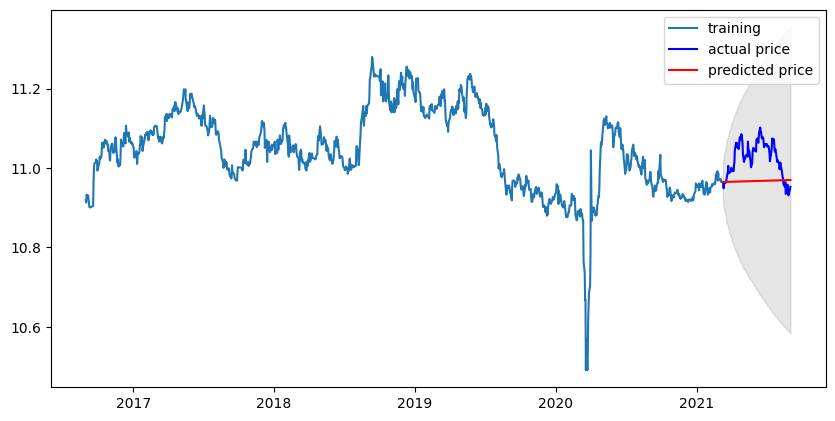

In [35]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [36]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18935613.685184665
MAE:  3757.6959552032263
RMSE:  4351.507059075587
MAPE: 5.98%


- 이번 경우에는 둘 다 상수를 그대로 놔두는게 결과가 더 좋았다.
- 중간에 예측한 것처럼 차분이 1일때 결과가 더 안 좋은거보니
- 빙그레는 완전 AR 모델이다!
- 상승 하강이 반복되며 전체적으로 일정한 수준을 유지할 것이라는 기대를 해도 좋다.

## 최종 결과 (1, 0, 0) 일 때 3.90%

---
---
---

# STEP 1 : 시계열 데이터 준비
## 서울 기준 열흘간의 매 시간 날씨 데이터
[출처](https://www.visualcrossing.com/weather-data)
- 칼럼 종류: Date time, Maximum Temperature, Minimum Temperature, Temperature을 포함한 22개
- Temperature 만 사용

In [37]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/history_data.csv'
df = pd.read_csv(dataset_filepath, index_col='Date time', parse_dates=True)
ts = df['Temperature']

ts.head()

Date time
2021-08-21 00:00:00    24.5
2021-08-21 01:00:00    24.4
2021-08-21 02:00:00    23.9
2021-08-21 03:00:00    24.0
2021-08-21 04:00:00    24.1
Name: Temperature, dtype: float64

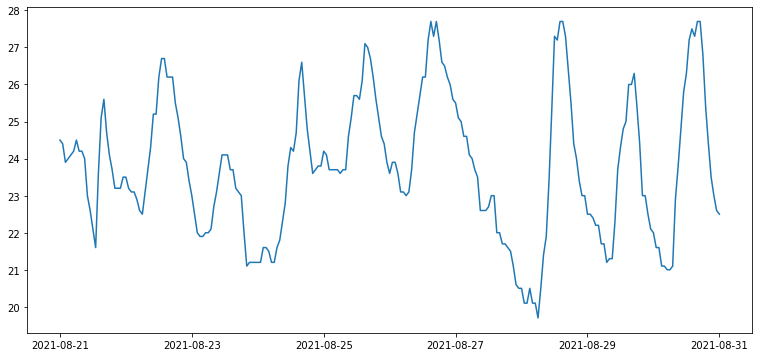

In [38]:
# 그래프 확인
# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- ~로그 변환~ 안하는게 낫다

In [39]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Temperature, dtype: float64)

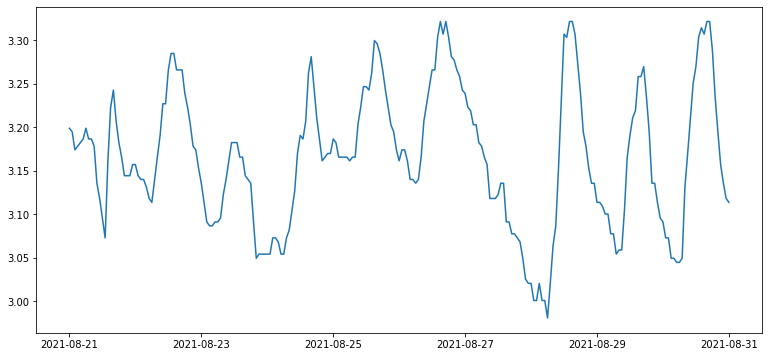

In [40]:
# 로그 변환 시도 후 다시 그래프 확인
ts_log = np.log(ts)
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인


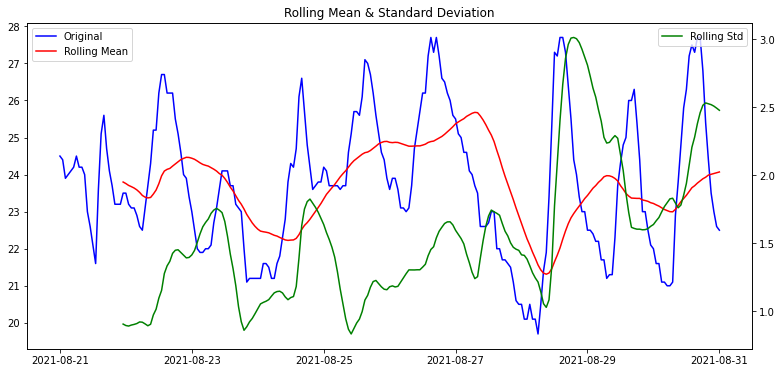

In [41]:
# 정성적 그래프 분석
# 하루는 24시간이 반복되므로 window를 24로 잡아봄

plot_rolling_statistics(ts, window=24)

In [42]:
# 정량적 Augmented Dicky-Fuller Test

augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -5.295403
p-value                          0.000006
#Lags Used                       4.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


In [43]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -5.226885
p-value                          0.000008
#Lags Used                       4.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


- 로그 변환 후 오히려 p value가 증가한다
- 변환 없이 원 값으로 진행하자
- `d=0`을 사용해도 될 것 같다.

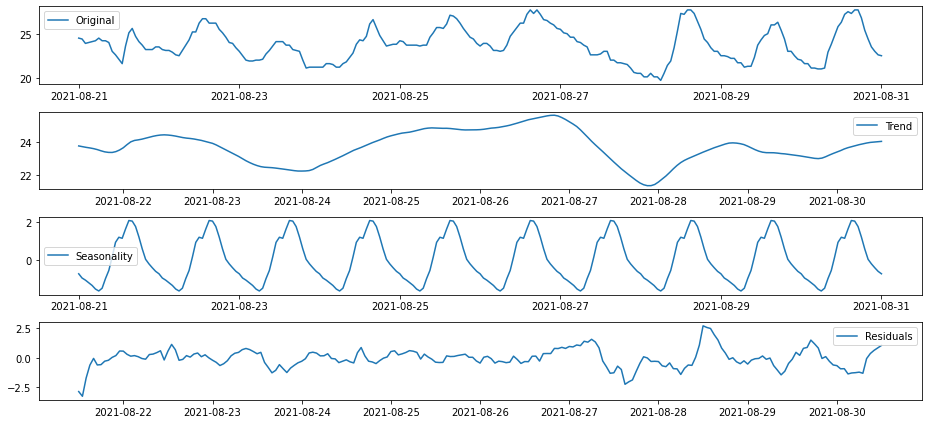

In [44]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts)#, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [45]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.555590
p-value                          0.000002
#Lags Used                       4.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

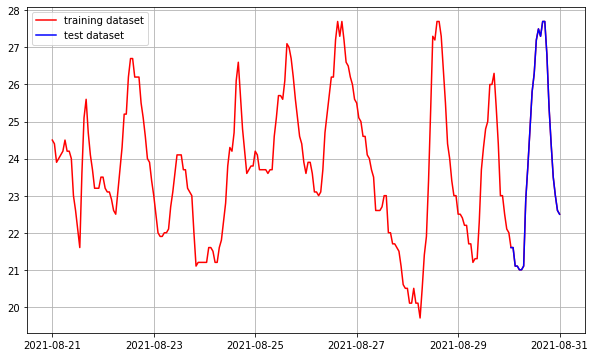

In [46]:
# 최근 24시간의 날씨를 테스트셋으로

train_data, test_data = ts[:-24], ts[-24:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r', label='training dataset')  
 # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

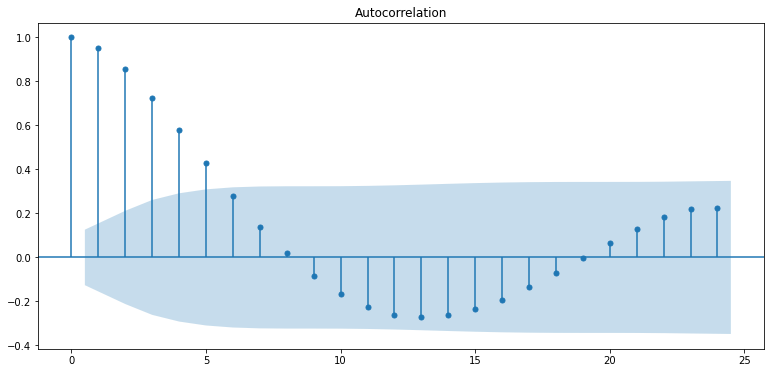

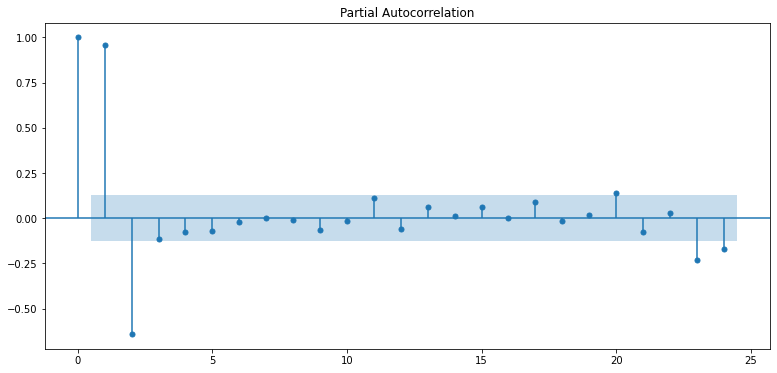

In [47]:
# ACF, PACF 그려보기

plot_acf(ts)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- `ACF` 그래프에서는 time lag이 6일때 파란 공간에 진입하므로 `q=5`

- `PACF` 그래프에서는 time lag이 3일때 파란 공간에 진입하므로 `p=2` 가 적당해보이긴 하는데..

- 일단 5는 너무 큰 수치 같아서 (2, 0, 0)에서 `q`만 바꿔가면서 시도하자

Results of Dickey-Fuller Test:
Test Statistic                -6.639470e+00
p-value                        5.455958e-09
#Lags Used                     1.300000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


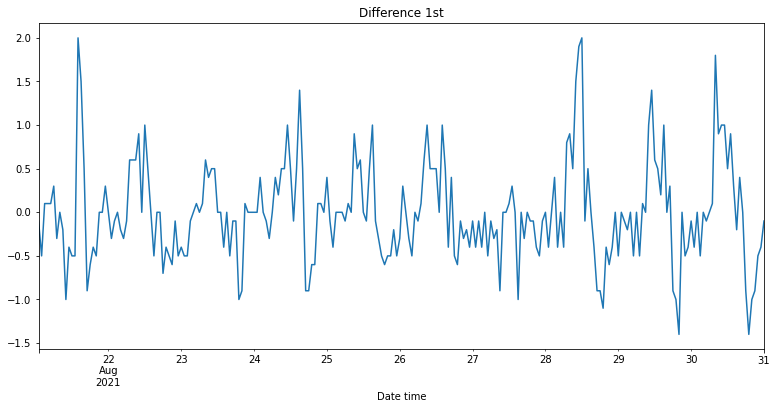

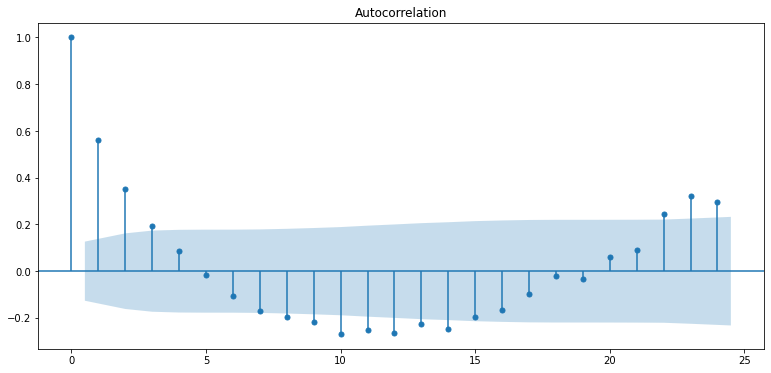

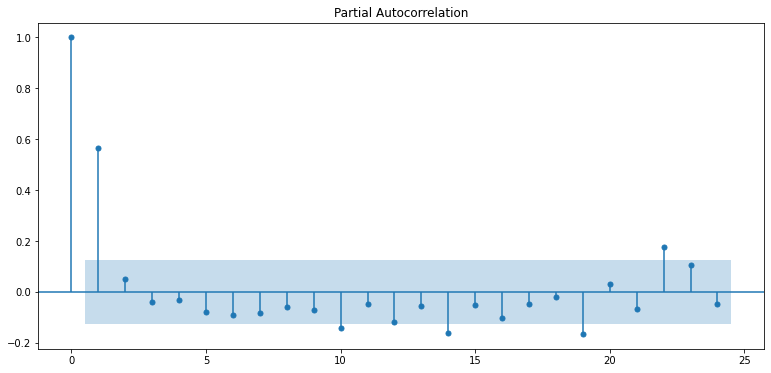

In [48]:
# 차분 안정성 확인

# 1차 차분 구하기
diff_1 = ts.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# ACF, PACF 다시 확인
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

- `d=1`일때는 `p=1`, `q=2`가 적당해보이긴 한다
- (1, 1, 0)으로 두고 `q`값을 바꿔가며 테스트

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [49]:
# ARIMA 모델 빌드와 훈련

# Build Model
model_202 = ARIMA(train_data, order=(2, 0, 2))  
fitted_m = model_202.fit(trend='c', disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:            Temperature   No. Observations:                  217
Model:                     ARMA(2, 2)   Log Likelihood                -131.794
Method:                       css-mle   S.D. of innovations              0.441
Date:                Wed, 01 Sep 2021   AIC                            275.588
Time:                        17:31:57   BIC                            295.867
Sample:                    08-21-2021   HQIC                           283.780
                         - 08-30-2021                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                23.7280      0.319     74.269      0.000      23.102      24.354
ar.L1.Temperature     1.7210      0.098     17.595      0.000       1.529       1.913
ar.L2.Temperature    -0.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be use

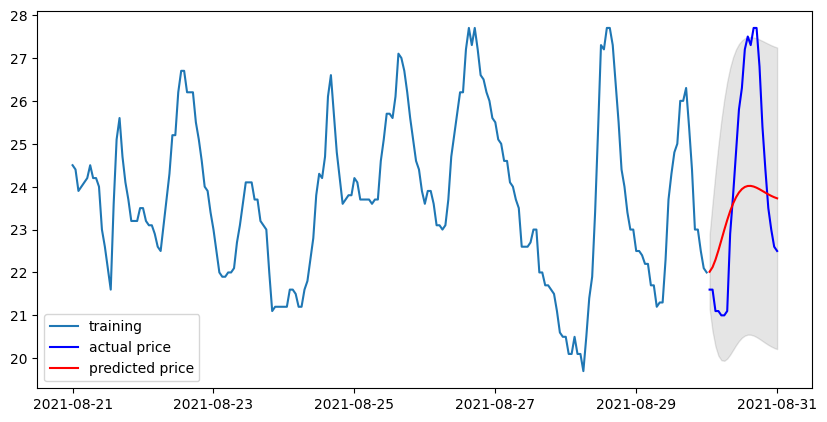

In [50]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [51]:
# 최종 예측 모델 정확도 측정(MAPE)
# 지수 변환 없이 값 그대로 사용

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)

mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4.214299108832196
MAE:  1.7190370619714017
RMSE:  2.0528758142742576
MAPE: 6.91%


In [53]:
# ARIMA 모델 빌드와 훈련

# Build Model
model_112 = ARIMA(train_data, order=(1, 1, 2))  
fitted_m = model_112.fit(trend='nc', disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:                  216
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -140.516
Method:                       css-mle   S.D. of innovations              0.463
Date:                Wed, 01 Sep 2021   AIC                            289.032
Time:                        17:33:34   BIC                            302.533
Sample:                    08-21-2021   HQIC                           294.486
                         - 08-30-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
ar.L1.D.Temperature     0.4911      0.182      2.701      0.007       0.135       0.847
ma.L1.D.Temperature     0.0253      0.191      0.132      0.895      -0.350       0.401
ma.L2.D.Temperat

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arim

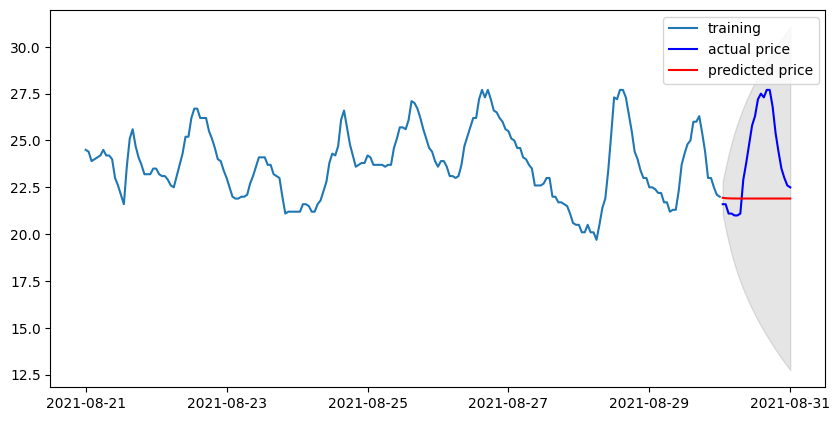

In [54]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [55]:
# 최종 예측 모델 정확도 측정(MAPE)
# 지수 변환 없이 값 그대로 사용

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)

mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10.588672327529247
MAE:  2.572950593911903
RMSE:  3.254024020736363
MAPE: 10.00%


- 차분이 없이 `d=0`으로 두고 진행했을때는 상수를 추가하는게 결과가 좋고,
- `d=1` 일때는 상수가 없을때 결과가 더 좋았다.. 신기하네
- (2, 0, 5) 까지 돌려보고 싶었으나 `q=3` 이상으로 설정하니 오류가 났다...ㅠㅠ
- (2, 0, 2) 일 때 가장 낮은 결과가 나와서 `q`를 더 올려보고 싶은데 아깝다..
- 좀 더 공부해서 확인해봐야겠다!

## 최종 결과 (2, 0, 2) 일 때 6.91%

---
---
---

# STEP 1 : 시계열 데이터 준비
## 최근 1년 간의 비트코인 시세
[출처](https://www.blockchain.com/ko/charts/market-price?timespan=60days)

- 칼럼 종류: Timestamp, market-price

In [56]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/market-price.csv'
df = pd.read_csv(dataset_filepath, index_col='Timestamp', parse_dates=True)
ts = df['market-price']

ts.head()

Timestamp
2020-09-01    11659.57
2020-09-02    11923.25
2020-09-03    11397.44
2020-09-04    10187.51
2020-09-05    10467.89
Name: market-price, dtype: float64

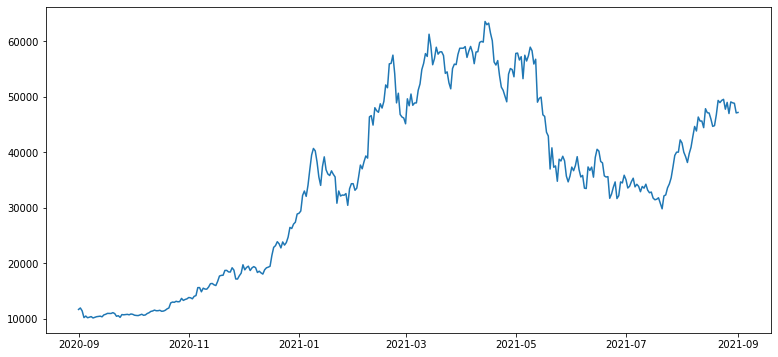

In [57]:
# 그래프 확인
# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [58]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: market-price, dtype: float64)

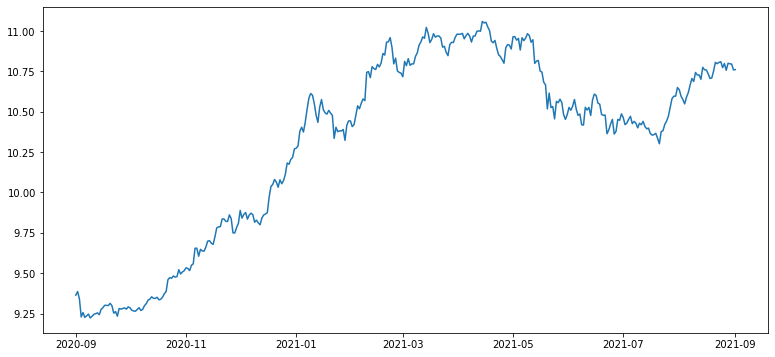

In [59]:
# 로그 변환 시도 후 다시 그래프 확인
ts_log = np.log(ts)
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인


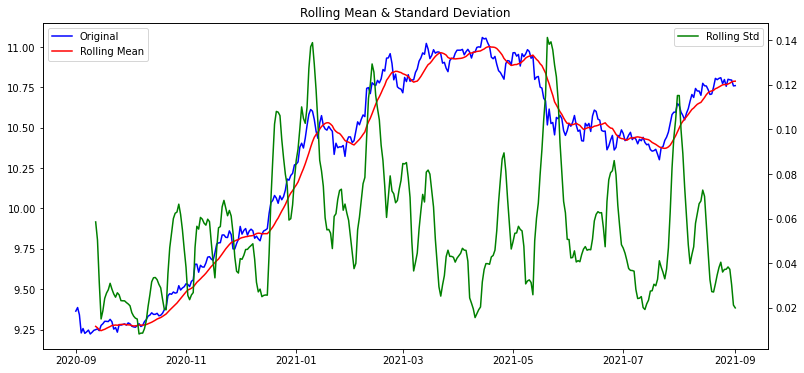

In [60]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_log)

In [61]:
#정량적 Augmented Dicky-Fuller Test

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts) # 로그 변환 전

Results of Dickey-Fuller Test:
Test Statistic                  -1.356430
p-value                          0.602977
#Lags Used                       2.000000
Number of Observations Used    363.000000
Critical Value (1%)             -3.448494
Critical Value (5%)             -2.869535
Critical Value (10%)            -2.571029
dtype: float64


In [62]:
augmented_dickey_fuller_test(ts_log) # 로그 변환 후

Results of Dickey-Fuller Test:
Test Statistic                  -1.439149
p-value                          0.563371
#Lags Used                       1.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


- 로그변환을 해줘도 수치의 변화가 크지 않다 ㅠㅠ
- `d=1` 이상이 무조건 필요한 상황

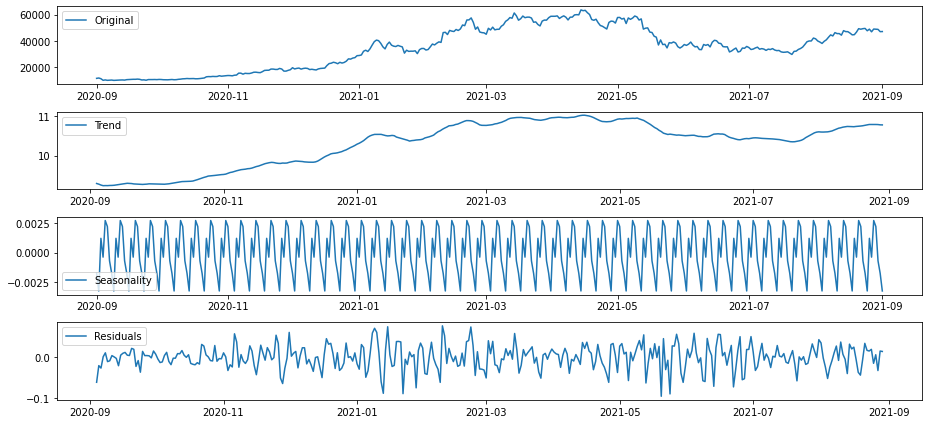

In [63]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log)#, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [64]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.094201e+01
p-value                        9.245381e-20
#Lags Used                     7.000000e+00
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

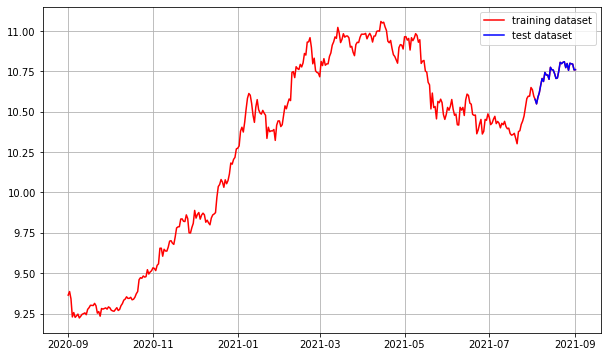

In [65]:
# 최근 30일 간의 가격을 테스트셋으로

train_data, test_data = ts_log[:-30], ts_log[-30:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
 # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

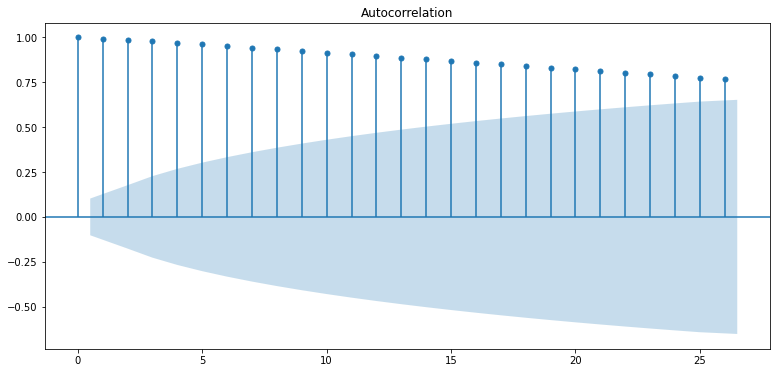

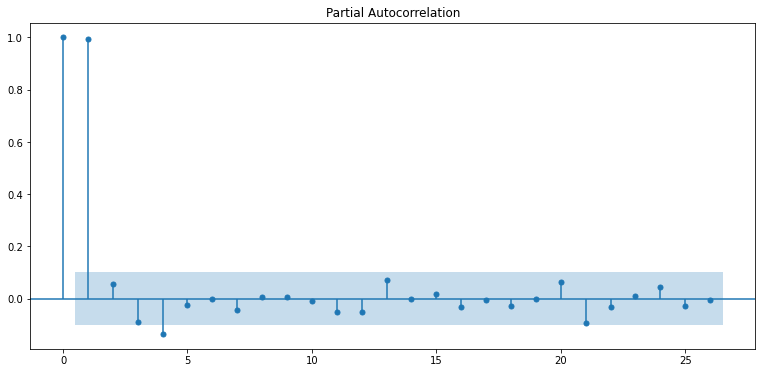

In [66]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 역시나 AR 모델에 가까운 형태가 나왔다.
- 차분해서 확인해봐야겠지만 삼성의 케이스를 생각해보면 ..
- (1,0,0) 부터 몇가지 시도해보자

Results of Dickey-Fuller Test:
Test Statistic                 -20.523575
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


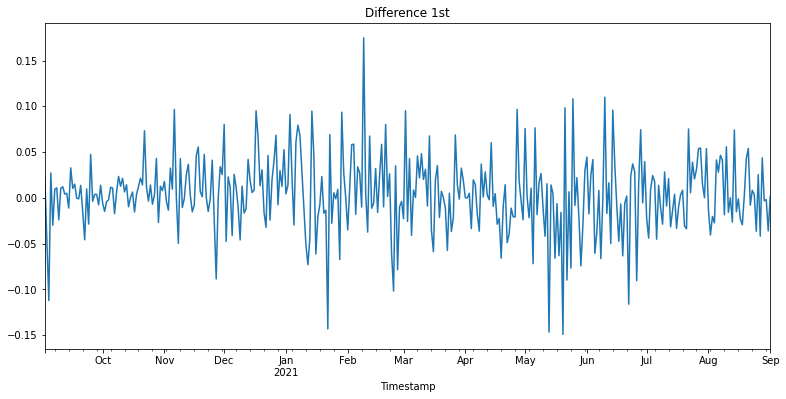

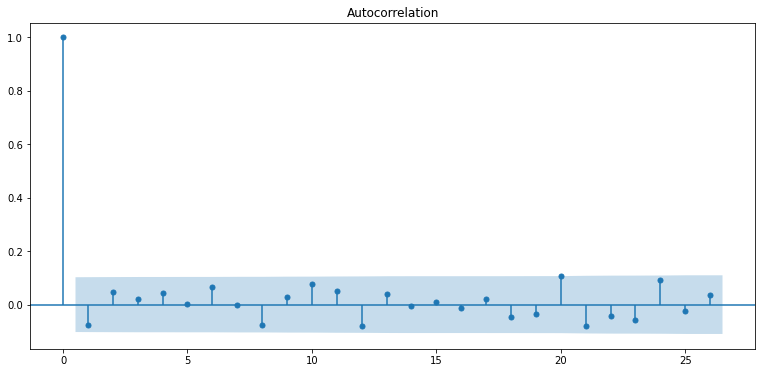

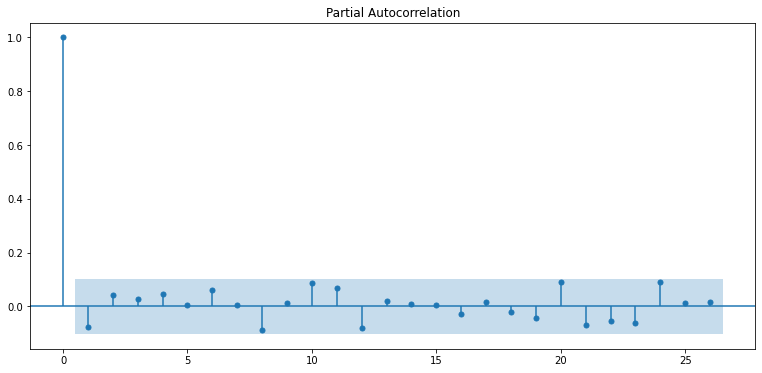

In [67]:
# 차분 안정성 확인

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# ACF, PACF 다시 확인
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

- 앞에서 몇번 본 형태라서 코멘트는 스킵
- (1, 1, 0) 부터 시도

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [68]:
# Build Model
model_100 = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model_100.fit(trend='nc', disp=-1)  
print(fitted_m.summary())


                              ARMA Model Results                              
Dep. Variable:           market-price   No. Observations:                  336
Model:                     ARMA(1, 0)   Log Likelihood                 578.459
Method:                       css-mle   S.D. of innovations              0.042
Date:                Wed, 01 Sep 2021   AIC                          -1152.917
Time:                        17:33:40   BIC                          -1145.283
Sample:                    09-01-2020   HQIC                         -1149.874
                         - 08-02-2021                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.market-price     1.0000   9.66e-06   1.03e+05      0.000       1.000       1.000
                                    Roots                                    
                  Real       

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

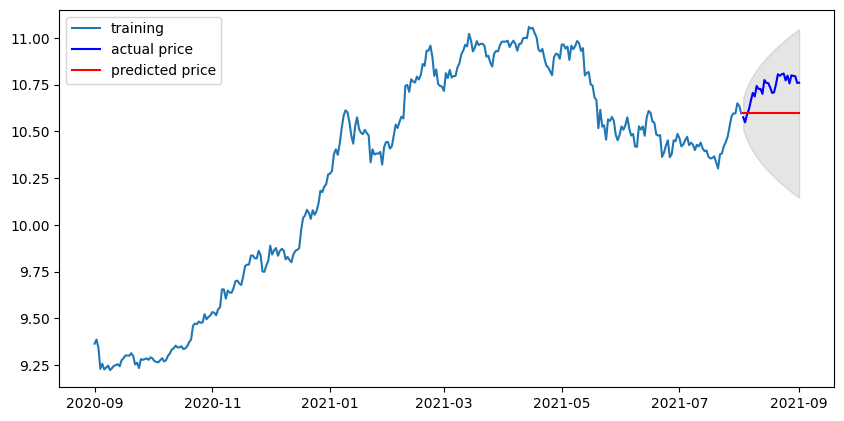

In [69]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [70]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  44411512.608213425
MAE:  6099.121872492584
RMSE:  6664.196321253856
MAPE: 12.94%


In [71]:
# Build Model
model_112 = ARIMA(train_data, order=(1, 1, 2))  
fitted_m = model_112.fit(trend='c', disp=-1)  
print(fitted_m.summary())


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

                             ARIMA Model Results                              
Dep. Variable:         D.market-price   No. Observations:                  335
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 588.862
Method:                       css-mle   S.D. of innovations              0.042
Date:                Wed, 01 Sep 2021   AIC                          -1167.725
Time:                        17:33:41   BIC                          -1148.654
Sample:                    09-02-2020   HQIC                         -1160.122
                         - 08-02-2021                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0036      0.003      1.361      0.173      -0.002       0.009
ar.L1.D.market-price     0.7849      0.219      3.578      0.000       0.355       1.215
ma.L1.D.mark

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


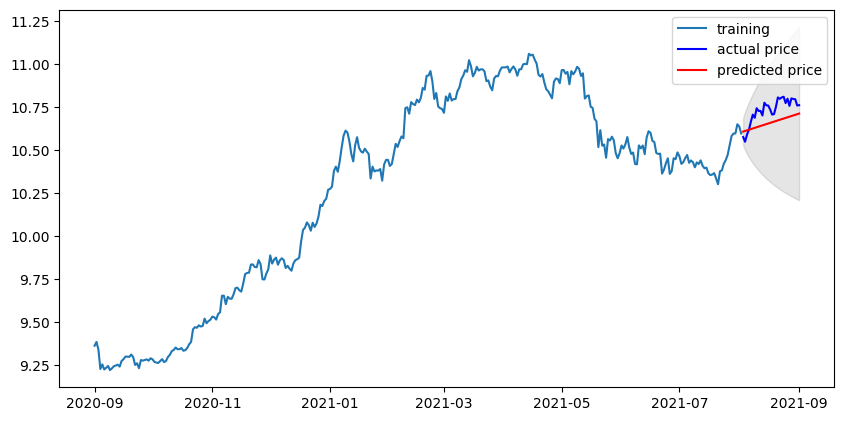

In [72]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [73]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  15317152.225795543
MAE:  3572.9916088269306
RMSE:  3913.7133550881754
MAPE: 7.62%


- 주식이랑 비슷한 결과가 나오지 않을까 했는데 꽤 다른 모양으로 정리되었다
- 삼성과 빙그래가 모두 완전 AR 모델처럼 정리되었는데
- 이건 특이하게 `p`와 `q`를 모두 가져가는 형태가 나왔다

## 최종 결과 (1, 1, 2) 일 때 7.62%

---
---
---

# 회고

중간중간 코멘트로 뭘 적어서 회고에 쓸 말이 별로 없긴 한데..

프로젝트 주제는 주가 예측이기는 했으나 빙그레를 해보고 나서는

주가 이외에 다른 걸 해야겠다 싶었다.

외부 요인이 많이 적용되어 날뛰는 종목은 결과가 안좋을게 뻔해서 고르고 싶지 않았고,

어느정도 안정적인 종목이라면 죄다 비슷비슷한 결과를 낼 것 같았으니까.

그래서 시계열로 의미가 있는 걸 찾아다 날씨 데이터를 선택했고

코드 복붙하다 로그 변환 지우는거 까먹어서 MAPE 90% 도 구경하는 등ㅋㅋ 연습이 많이 되었다.

마지막 비트코인은, 어차피 3개는 채운 것 같으니까 

오히려 많이 왔다갔다 하는 데이터를 써보자. 외부 요인에 아주 취약한 걸 써보자!

라는 생각으로 골랐는데 딱히 그렇지만도 않았다... ㅋㅋㅋ

이리저리 검색해가면서 필요한 지식을 기워가는데 통계 베이스가 부족한걸 너무 실감했고ㅠㅠ

뭐 하나 할 때마다 매번 부족함만 느끼고 있다😂